In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dl1_data_handler.reader import DL1DataReaderSTAGE1, DL1DataReaderDL1DH
import h5py
import os


def unison_shuffled_copies(a, b):
    """shuffle proton/gamma images and proton/gamma labels the same way"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [40]:
#load training images
gamma_images = np.load("/home/woody/caph/mppi109h/gamma10000.npy")
proton_images = np.load("/home/woody/caph/mppi109h/proton10000.npy")

In [46]:
# example derived from /home/woody/caph/mpp228/ML/CTA/dl1-data-handler_stage1/notebooks/dl1reading_stage1.ipynb

def descend_obj(obj, sep='\t', res_str=''):
    """
    Iterate through groups in a HDF5 file and prints the groups and 
    datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
        for key in obj.keys():
            try:
                res_str += '%s-%s: %s\n' % (sep, key, obj[key])
            except:
                res_str += '%s-%s: %s\n' % (sep, key, 'problem:(')
            res_str = descend_obj(obj[key], sep=sep+sep, res_str=res_str)
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            try:
                res_str += '%s+%s: %s\n' % (sep+sep, key, obj.attrs[key])
            except:
                res_str += '%s+%s: %s\n' % (sep+sep, key, 'problem here')
    return res_str

mode = 'mlgrid_gamma-diffuse' #'mlgrid_proton', 'mlgrid_gamma-diffuse'
if mode == 'mlgrid_proton':
    folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
    folder += 'Prod5_Paranal_AdvancedBaseline_NSB1x_proton_North_20deg_ctapipe_v0.10.5_DL1/'
    fn0 = 'proton_20deg_0deg_run14656___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5'
elif mode == 'mlgrid_gamma-diffuse':
    folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/'
    folder += 'Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/'
    fn0 = 'gamma_20deg_0deg_run5996___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5'
fn = folder + fn0


test = DL1DataReaderSTAGE1(["/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/proton_50000_images.h5"],
                                 mode='mono',
                                 #example_identifiers_file="./examples.h5",
                                 selected_telescope_types=["LST_LST_LSTCam"],
                                 selected_telescope_ids = {"LST_LST_LSTCam": [1]},
                                 image_channels = ['image', 'peak_time', 'image_mask'],
                                 parameter_list = ['hillas_intensity', 'hillas_x'],
                                 event_info = ["true_energy", "true_alt", "true_az"])



#test_path = fn2reader("/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1")
print(test)

ImportError: Numba needs NumPy 1.20 or less

In [4]:
print(gamma_images.shape)
print(proton_images.shape)

(10000, 110, 110)
(10000, 110, 110)


In [5]:
#prepare for training and testing
images_whole = np.concatenate((gamma_images, proton_images))
proton_label = np.ones(10000)
gamma_label = np.zeros(10000)
labels_whole = np.concatenate((proton_label, gamma_label))

print(images_whole.shape)
print(labels_whole.shape)

#shuffle trainings data
images_whole, labels = unison_shuffled_copies(images_whole,labels_whole) #does function work on axis 0 for images?
print(labels)

#split traings set and test set
test_images = images_whole[18000:,:,:]
test_labels = labels[18000:]
images = images_whole[:18000,:,:]
labels = labels[:18000]
#prepare for neural network input
images = np.expand_dims(images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
print(test_labels.shape)
print(test_images.shape)
print(labels.shape)
print(images.shape)

input_shape = (110, 110, 1)


(20000, 110, 110)
(20000,)
[0. 1. 0. ... 1. 0. 1.]
(2000,)
(2000, 110, 110, 1)
(18000,)
(18000, 110, 110, 1)


/tmp/ipykernel_2741/3422886546.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 9000 + 1) instead
  rand = np.random.random_integers(0,9000)


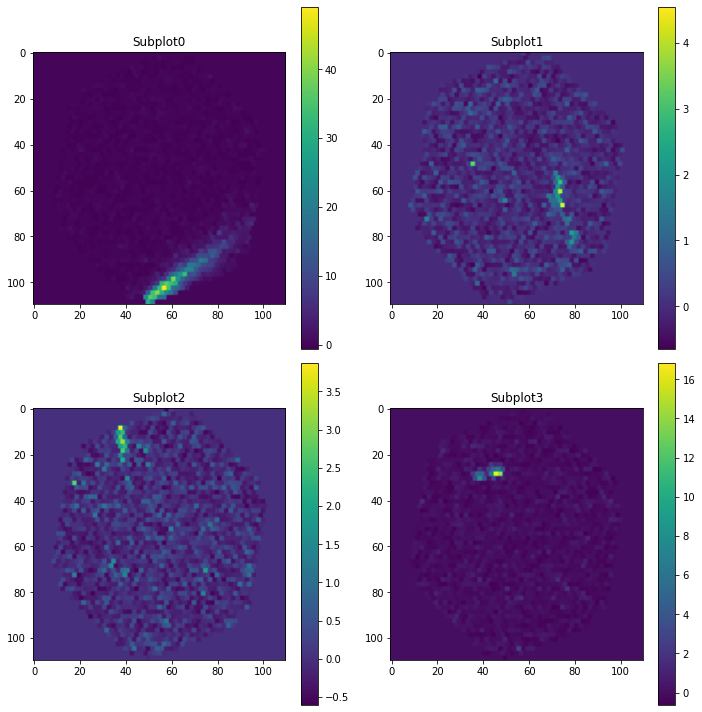

In [6]:
#print examples of gamma events to see how the data looks like
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(10, 10))

for a in range(rows*cols):
    rand = np.random.random_integers(0,9000)
    b = gamma_images[a+rand,:,:]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    plt.colorbar()
fig.tight_layout()    
plt.show()

/tmp/ipykernel_2741/3781195722.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 9000 + 1) instead
  rand = np.random.random_integers(0,9000)


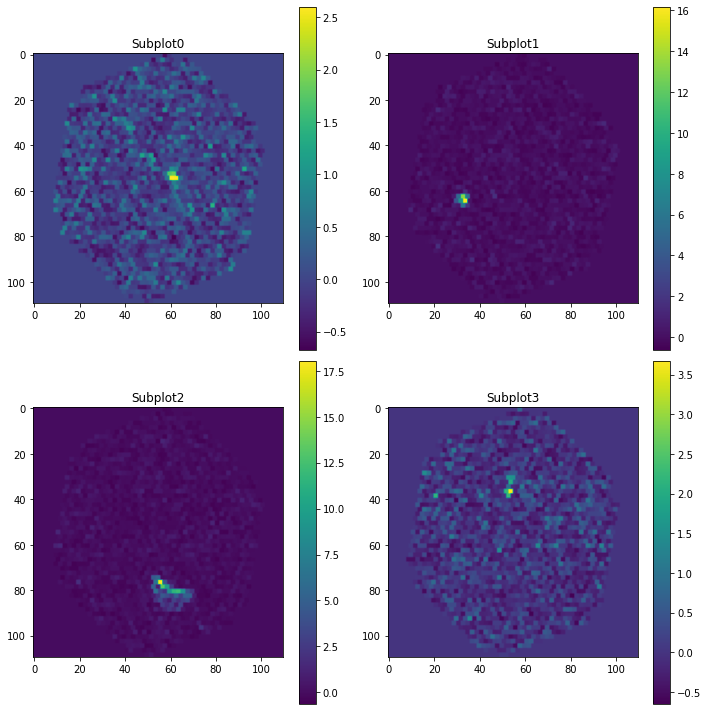

In [7]:
#print examples of proton events to see how the data looks like
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(10, 10))

for a in range(rows*cols):
    rand = np.random.random_integers(0,9000)
    b = proton_images[a+rand,:,:]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    plt.colorbar()
fig.tight_layout()    
plt.show()

In [8]:
#images_whole = np.expand_dims(images_whole, axis=-1)
#labels_whole = np.expand_dims(labels_whole, axis=-1)

Epoch 1/10
507/507 [==============================] - 35s 68ms/step - loss: 0.8017 - accuracy: 0.5027 - val_loss: 0.6973 - val_accuracy: 0.4889
Epoch 2/10
507/507 [==============================] - 35s 70ms/step - loss: 0.6944 - accuracy: 0.5017 - val_loss: 0.6927 - val_accuracy: 0.5139
Epoch 3/10
507/507 [==============================] - 36s 72ms/step - loss: 0.6937 - accuracy: 0.5359 - val_loss: 0.6943 - val_accuracy: 0.4956
Epoch 4/10
507/507 [==============================] - 36s 71ms/step - loss: 0.6881 - accuracy: 0.5503 - val_loss: 0.6923 - val_accuracy: 0.5289
Epoch 5/10
507/507 [==============================] - 37s 73ms/step - loss: 0.6800 - accuracy: 0.5774 - val_loss: 0.6909 - val_accuracy: 0.5250
Epoch 6/10
507/507 [==============================] - 35s 70ms/step - loss: 0.6740 - accuracy: 0.5962 - val_loss: 0.6867 - val_accuracy: 0.5461
Epoch 7/10
507/507 [==============================] - 36s 70ms/step - loss: 0.6560 - accuracy: 0.6201 - val_loss: 0.6983 - val_accuracy:

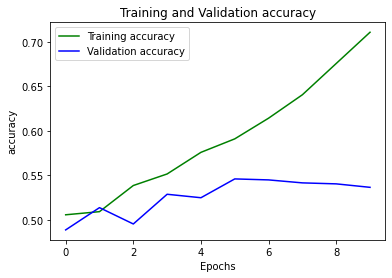

63/63 - 1s - loss: 0.8592 - accuracy: 0.5325

Test accuracy: 0.5325000286102295
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 110, 110, 16)      80        
_________________________________________________________________
spatial_dropout2d_21 (Spatia (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 110, 110, 16)      1040      
_________________________________________________________________
spatial_dropout2d_22 (Spatia (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 110, 110, 16)      1040      
_________________________________________________________________
spatial_dropout2d_23 (Spatia (None, 110, 110, 16)      0         
_______________________________________

In [26]:

#create neural network
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding='same', activation='relu', input_shape = (110,110,1)),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding='same', activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding='same', activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Conv2D(filters = 8, kernel_size = 2, padding='same', activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile neural network
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#train neural network
history = model.fit(images, labels, validation_split = 0.1, epochs=10)

print(history) 
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#check accuracy with testimages
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

print(model.summary())

#save model
#model.save("/home/nico/Schreibtisch/Master Thesis/keras-model-cnn")


In [ ]:
"""
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 2, padding='same', activation='relu', input_shape = (110,110,1)),
    tf.keras.layers.SpatialDropout2D(0.4),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 2, padding='same', activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.4),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, padding='same', activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.4),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
"""

In [ ]:
""""
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(110, 110,1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', ),
    tf.keras.layers.Dense(2, activation='softmax')
])
"""

#daten überprüfen
#mehr bilder verwenden

